In [231]:
import matplotlib.pyplot as plt
import numpy as np
# ^^^ pyforest auto-imports - don't write above this line

# Library imports
import pyforest
import struct
import skimage.transform
import keras

# Dependency imports
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder

# Japanese Handwriting Recognition Project

![Japanese_Kana_Chart](img/variant-hentaigana-chart.jpg)

## Agenda

This project aims to accurately predict Japanese handwriting and display the corresponding text output correctly. Using the three main Japanese language writing systems (Kanji, Hiragana, Katakana), the data is from the [ETL Character Database](http://etlcdb.db.aist.go.jp/), which includes over a million of Japanese characters hand-written and reorganized by the [National Institute of Advanced Industrial Science and Technology (AIST)](http://www.jeita.or.jp/english/). 

## Data Information

- Each file contains 5 data sets except ETL8G_33
- Each data set contains 956 characters written by a writer.
- Each writer wrote 10 sheets (genkouyoushi) per data set

### Japanese Character Dataset Info

- **Hiragana (ETL 8)**
    - 71 hiragana characters (46 unique + 29 dipthongs)
    - 160 writers
    - 8199 records (genkouyoushi sheets) 
    - 1,529,600 unique characters (shared with kanji chars in the same files)
- **Kanji (ETL 8)**
    - 883 daily use kanji
    - 160 writers
    - 8199 records 
    - 1,529,600 unique characters (shared with hiragana chars in the same files)
- **Katakana (ETL 1)**
    - 46 katakana characters (46 unique, dipthongs not included as they are phonetically identical to hiragana)
    - 1411 writers
    - 2052 records
    - 175,359,080 unique katakana characters

### Import & Read Hiragana

In [232]:
hira_kanji_record = 8199

In [233]:
# Reading the Hiragana ETL8G File
def read_ETL8G(f):
    s = f.read(hira_kanji_record)
    r = struct.unpack('>2H8sI4B4H2B30x8128s11x', s)
    iF = Image.frombytes('F', (128, 127), r[14], 'bit', 4)
    iL = iF.convert('L')
    return r + (iL,)

In [234]:
# Function to read the binary code present in each of the 33 files included in the ETL8G folder
def read_hiragana():
    # Characters = 71, writers = 160, y = 127, x = 128
    hiragana = np.zeros([71, 160, 127, 128], dtype = np.uint8)

    for j in range(1, 33):
        filename = 'data/ETL8G/ETL8G_{:02d}'.format(j)
        with open(filename, 'rb') as f:
            for id_dataset in range(5):
                moji = 0
                for i in range(956):
                    r = read_ETL8G(f)
                    if b'.HIRA' in r[2] or b'.WO.' in r[2]:
                        if not b'KAI' in r[2] and not b'HEI' in r[2]:
                            hiragana[moji, (j - 1) * 5 + id_dataset] = np.array(r[-1])
                            moji += 1
    np.savez_compressed('hiragana.npz', hiragana)

In [235]:
# Running the Function Above
# read_hiragana()

In [236]:
hiragana_data = np.load('hiragana.npz')
hira_test = hiragana_data.f.arr_0

In [237]:
hira_test

array([[[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        ...,

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
    

### Import & Read Kanji

In [238]:
def read_kanji():
    # Characters = 883, writers = 160, y = 127, x = 128
    kanji = np.zeros([883, 160, 127, 128], dtype=np.uint8)
    for i in range(1, 33):
        filename = 'data/ETL8G/ETL8G_{:02d}'.format(i)
        with open(filename, 'rb') as f:
            for dataset in range(5):
                char = 0
                for j in range(956):
                    r = read_ETL8G(f)
                    if not (b'.HIRA' in r[2] or b'.WO.' in r[2]): 
                        kanji[char, (i - 1) * 5 + dataset] = np.array(r[-1])
                        char += 1
    np.savez_compressed("kanji.npz", kanji)

In [239]:
# read_kanji()

In [240]:
kanji_data = np.load('kanji.npz')
kanji_test = kanji_data.f.arr_0

In [241]:
kanji_test

array([[[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        ...,

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
    

### Import & Read Katakana

In [242]:
kana_record = 2052

In [243]:
# Reading in the Katakana ETL1 File
def read_ETL1(total_sheets, f):
    s = f.read(kana_record)
    r = struct.unpack('>H2sH6BI4H4B4x2016s4x', s)
    iF = Image.frombytes('F', (64, 63), r[18], 'bit', 4)
    iL = iF.convert('L')
    return r + (iL,)

In [244]:
def read_katakana():
    # Character type = 46, writers = 1411, y = 63, x = 64
    katakana = np.zeros([46, 1411, 63, 64], dtype=np.uint8)
    counter = 0
    moji = 0
    for k in range(7, 14):
        filename = 'data/ETL1/ETL1C_{:02d}'.format(k)
        with open(filename, 'rb') as f:
            total_sheets = 0
            categories = 8
            if k == 13:
                categories = 3
            for j in range(categories):
                incrimenter = 0
                person = 0
                sheets = 1411
                if k == 9 and j == 4:
                    sheets = 1410
                elif k == 12 and j == 1:
                    sheets = 1410
                for i in range(sheets):
                    r = read_ETL1(total_sheets, f)
                    total_sheets += sheets
                    if k < 11 or (k >= 11 and b' I' not in r[1] and b' E' not in r[1] and b'WI' not in r[1] and b' U' not in r[1] and b'WE' not in r[1]):
                        pixels = np.array(r[-1])
                        for row in pixels:
                            for i in range(len(row)):
                                if row[i] == 1 or row[i] == 2:
                                    row[i] = 0
                        katakana[moji, person] = pixels
                        incrimenter = 1
                        person += 1
                moji += incrimenter
    np.savez_compressed('katakana.npz', katakana)

In [245]:
# read_katakana()

In [246]:
katakana_data = np.load('katakana.npz')
kana_test = katakana_data.f.arr_0

In [247]:
kana_test

array([[[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        ...,

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 3, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
    

## Visualizing Characters

### Visualizing Hiragana

In [248]:
# Visualizing Hiragana
def visualize_hiragana():
    for j in range(1, 2):
        filename = 'data/ETL8G/ETL8G_{:02d}'.format(j)
        with open(filename, 'rb') as f:
            for id_dataset in range(1):
                new_img = Image.new('L', (128*32, 128*30))
                for i in range(956):
                    r = read_ETL8G(f)
                    if b'.HIRA' in r[2]:
                        print(r[:4])

In [249]:
visualize_hiragana()

(1, 9250, b'A.HIRA  ', 1)
(1, 9252, b'I.HIRA  ', 16)
(1, 9254, b'U.HIRA  ', 31)
(1, 9256, b'E.HIRA  ', 46)
(1, 9258, b'O.HIRA  ', 61)
(1, 9259, b'KA.HIRA ', 76)
(1, 19007, b'HEI.HIRA', 83)
(1, 9260, b'GA.HIRA ', 91)
(2, 9261, b'KI.HIRA ', 1)
(2, 9262, b'GI.HIRA ', 16)
(2, 9263, b'KU.HIRA ', 31)
(2, 9264, b'GU.HIRA ', 46)
(2, 9265, b'KE.HIRA ', 61)
(2, 9266, b'GE.HIRA ', 76)
(2, 9267, b'KO.HIRA ', 91)
(3, 9268, b'GO.HIRA ', 193)
(3, 9269, b'SA.HIRA ', 208)
(3, 9270, b'ZA.HIRA ', 223)
(3, 9271, b'SHI.HIRA', 238)
(3, 9272, b'JI.HIRA ', 253)
(3, 9273, b'SU.HIRA ', 268)
(3, 9274, b'ZU.HIRA ', 283)
(4, 9275, b'SE.HIRA ', 289)
(4, 9276, b'ZE.HIRA ', 304)
(4, 9277, b'SO.HIRA ', 319)
(4, 9278, b'ZO.HIRA ', 334)
(4, 9279, b'TA.HIRA ', 349)
(4, 9280, b'DA.HIRA ', 364)
(4, 9281, b'CHI.HIRA', 378)
(5, 9282, b'JI.HIRA ', 385)
(5, 9284, b'TSU.HIRA', 400)
(5, 9285, b'ZU.HIRA ', 415)
(5, 9286, b'TE.HIRA ', 430)
(5, 9287, b'DE.HIRA ', 445)
(5, 9288, b'TO.HIRA ', 460)
(5, 9289, b'DO.HIRA ', 475)
(6, 9290

In [250]:
def one_kana():
    filename = 'data/ETL8G/ETL8G_01'
    counter = 0
    with open(filename, 'rb') as f:
        for id_dataset in range(5):
            for i in range(956):
                r = read_ETL8G(f)
                if b'.WO.' in r[2]:
                    iE = Image.eval(r[-1], lambda x: 255-x*16)
                    fn = 'kana_visualization.png'.format((r[0]-1)%20+1, hex(r[1])[-4:])
                    # iE.save(fn, 'PNG')

IndentationError: unexpected indent (<ipython-input-250-11f659f7e7e3>, line 2)

In [62]:
one_kana()

- Kana Sample Visualization ![kana](img/kana_visualization.png)

### Visualizing Kanji

In [59]:
def visualize_kanji():
    for j in range(1, 2):
        filename = 'data/ETL8G/ETL8G_{:02d}'.format(j)
        with open(filename, 'rb') as f:
            for id_dataset in range(1):
                new_img = Image.new('L', (128*32, 128*30))
                for i in range(956):
                    r = read_ETL8G(f)
                    if not (b'.HIRA' in r[2] or b'.WO.' in r[2]):
                        print(r[:4])

In [187]:
visualize_kanji()

(1, 12326, b'AI.MEDER', 2)
(1, 12369, b'I.YUDANE', 3)
(1, 12397, b'ICHI.HIT', 4)
(1, 12608, b'UN.KUMO ', 5)
(1, 12639, b'EN.MARU ', 6)
(1, 12838, b'OU.KIMI ', 7)
(1, 12863, b'KA.NANI ', 8)
(1, 12880, b'KA.HI   ', 9)
(1, 12913, b'KAI.AU  ', 10)
(1, 13100, b'KAI.KIZA', 11)
(1, 13143, b'KAKU.KAW', 12)
(1, 13361, b'KAN.TSUK', 13)
(1, 13403, b'KAN.YAKA', 14)
(1, 13429, b'KI.MARE ', 15)
(1, 13613, b'KI.SHIRU', 17)
(1, 13657, b'KYUU.YAS', 18)
(1, 13677, b'GYUU.USH', 19)
(1, 13862, b'KYOU.TOM', 20)
(1, 13898, b'KYOKU.MA', 21)
(1, 13927, b'KU.     ', 22)
(1, 14136, b'KEI.TSUN', 23)
(1, 14173, b'GEI.UERU', 24)
(1, 14196, b'KEN.WARI', 25)
(1, 14385, b'KEN.KEWA', 26)
(1, 14405, b'KO.INISH', 27)
(1, 14444, b'GO.KATAR', 28)
(1, 14461, b'KOU.KUCH', 29)
(1, 14657, b'KOU.MINA', 30)
(1, 14695, b'GOU.AU  ', 32)
(1, 14906, b'SA.SHIRA', 33)
(1, 14938, b'SAI.NA  ', 34)
(1, 14974, b'SATSU.HA', 35)
(1, 15165, b'SAN.KAIK', 36)
(1, 15183, b'SHI.HAJI', 37)
(1, 15200, b'SHI.SHIN', 38)
(1, 15217, b'SHI.MOTO', 39)


(8, 14376, b'KEN.KINU', 695)
(8, 14400, b'GEN.KOTO', 696)
(8, 14430, b'GO.ITSUT', 697)
(8, 14457, b'KOU.ISAO', 698)
(8, 14639, b'KOU.YASU', 699)
(8, 14683, b'KOU.ARAG', 700)
(8, 14894, b'KON.MAJI', 702)
(8, 14930, b'SAI.WAZA', 703)
(8, 14958, b'SAKU.TSU', 704)
(8, 15158, b'SAN.CHIR', 705)
(8, 15179, b'SHI.FUBI', 706)
(8, 15192, b'SHI.YUBI', 707)
(8, 15212, b'SHI.KOTO', 708)
(8, 15229, b'JI.MOTSU', 709)
(8, 15415, b'SHICHI.N', 710)
(8, 15446, b'SYA.KURU', 711)
(8, 15475, b'SYU.KUBI', 712)
(8, 15654, b'SYUU.HIR', 713)
(8, 15685, b'JUU.OMOI', 714)
(8, 15720, b'SYO.ORU ', 715)
(8, 15905, b'SYOU.TAE', 717)
(8, 15944, b'SYOU.TER', 718)
(8, 15983, b'JOU.TSUN', 719)
(8, 16180, b'SHIN.KOK', 720)
(8, 16202, b'SHIN.SUS', 721)
(8, 16426, b'SEI.IKIO', 722)
(8, 16442, b'SEI.SHIR', 723)
(8, 16464, b'SEKI.ISH', 724)
(8, 16482, b'SETSU.TO', 725)
(8, 16501, b'SEN.ASAI', 726)
(8, 16711, b'SO.SHIRO', 727)
(8, 16758, b'SOU.HASH', 728)
(8, 16941, b'SOKU.ASH', 729)
(8, 16955, b'SON.HERU', 730)
(8, 16982, b'T

In [69]:
def one_kanji():
    filename = 'data/ETL8G/ETL8G_01'
    counter = 0
    with open(filename, 'rb') as f:
        for id_dataset in range(5):
            for i in range(956):
                r = read_ETL8G(f)
                if not (b'.HIRA' in r[2] or b'.WO.' in r[2]):
                    iE = Image.eval(r[-1], lambda x: 255-x*16)
                    fn = 'kanji_visualization.png'.format((r[0]-1)%20+1, hex(r[1])[-4:])
                    # iE.save(fn, 'PNG')

In [70]:
one_kanji()

- Kanji Sample Visualization: ![kanji](img/kanji_visualization.png)

## Feature Engineering

- The image dimensions need to be resized for the ML model to work on them. Resizing to 64x64 is an option, but for processing speed and time they will instead be resized to 32x32 pixels.

### Resizing Hiragana Images

In [184]:
# 71 unique classes of hiragana (including dipthongs)
hiragana_class = 71

# Image dimensions
img_row, img_col = 32, 32

In [185]:
hiragana_table = np.load('hiragana.npz')['arr_0'].reshape([-1, 127, 128]).astype(np.float32)
hiragana_table = hiragana_table/np.max(hiragana_table)

In [186]:
hiragana_train = np.zeros([hiragana_class * 160, img_row, img_col], dtype = np.float32)

for i in range(hiragana_class * 160):
    hiragana_train[i] = skimage.transform.resize(hiragana_table[i], (img_row, img_col))

### Resizing Kanji Images

In [188]:
# 879 unique classes of kanji (most daily used kanji)
kanji_class = 873

In [189]:
kanji_table = np.load('kanji.npz')['arr_0'].reshape([-1, 127, 128]).astype(np.float32)
kanji_table = kanji_table/np.max(kanji_table)

- The kanji and hiragana characters share the ECT8 dataset, and they are not intuitively arranged. This accounts for this so hiragana are not mistakenly classified as kanji characters.

In [190]:
kanji_train = np.zeros([kanji_class * 160, img_row, img_col], dtype = np.float32)

for i in range((kanji_class + 4) * 160):
    if int(i / 160) != 88 and int( i / 160) != 219 and int( i / 160) != 349 and int( i / 160) != 457:
        if int(i / 160) < 88:
            kanji_train[i] = skimage.transform.resize(kanji_table[i], (img_row, img_col))
        if int(i/160) > 88 and int(i/160) < 219:
            kanji_train[i-160] = skimage.transform.resize(kanji_table[i], (img_row, img_col))
        if int(i/160) > 219 and int(i/160) < 349:
            kanji_train[i-320] = skimage.transform.resize(kanji_table[i], (img_row, img_col))
        if int(i/160) > 349 and int(i/160) < 457:
            if int(i/160) > 457:
                kanji_train[i-640] = skimage.transform.resize(kanji_table[i], (img_row, img_col))

### Resizing Katakana Images

In [191]:
# 71 frequently used katakana characters (including dipthongs)
katakana_class = 46

In [192]:
katakana_table = np.load('katakana.npz')['arr_0'].reshape([-1, 63, 64]).astype(np.float32)
katakana_table = katakana_table/np.max(katakana_table)

In [193]:
katakana_train = np.zeros([katakana_class * 1411, img_row, img_col], dtype = np.float32)

for i in range(katakana_class * 1411):
    katakana_train[i] = skimage.transform.resize(katakana_table[i], (img_row, img_col))

## Final Visualization Tables

- Checking that our finalized data was extracted and correctly, and is readable in the correct visual format.

### Hiragana Table

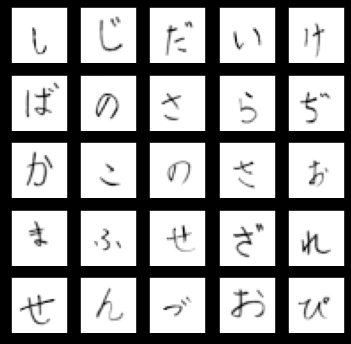

In [226]:
plt.figure(figsize = (6, 6)).patch.set_facecolor('black')
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(hiragana_train[i], cmap = plt.cm.binary)
plt.show();

### Kanji Table

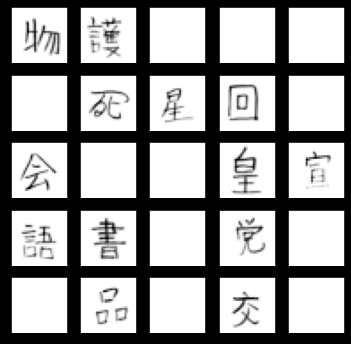

In [227]:
plt.figure(figsize = (6, 6)).patch.set_facecolor('black')
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(kanji_train[i], cmap = plt.cm.binary)
plt.show();

### Katakana Table

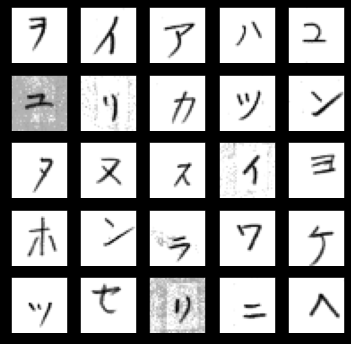

In [228]:
plt.figure(figsize = (6, 6)).patch.set_facecolor('black')
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(katakana_train[i], cmap = plt.cm.binary)
plt.show();

## Model Preparation

### Creating Labels

In [194]:
y_labels_hiragana = np.repeat(np.arange(kana_class), 160)
y_labels_kanji = np.repeat(np.arange(kanji_class), 160)
y_labels_katakana = np.repeat(np.arange(katakana_class), 1411)

### Train-Test Split

#### Hiragana Train-Test Split

In [196]:
hiragana_train, hiragana_test, hiragana_labels, hiragana_test_labels = train_test_split(
                                                    hiragana_train,
                                                    y_labels_hiragana,
                                                    random_state=42,
                                                    test_size=0.2)

#### Kanji Train-Test Split

In [197]:
kanji_train, kanji_test, kanji_labels, kanji_test_labels = train_test_split(
                                                    kanji_train,
                                                    y_labels_kanji,
                                                    random_state=42,
                                                    test_size=0.2)

#### Katakana Train-Test Split

In [198]:
katakana_train, katakana_test, katakana_labels, katakana_test_labels = train_test_split(
                                                    katakana_train,
                                                    y_labels_katakana,
                                                    random_state=42,
                                                    test_size=0.2)

### Multiclass Classification

- For classification of multiple input types and target variables, we need to create a cross-validation set as well as OneHotEncode our y values (y_train, y_test, y_val)

#### Hiragana Multiclass Preparation

In [230]:
# Labels are our y values
hira_X_train, hira_X_val, hira_y_train, hira_y_val =\
    train_test_split(hiragana_train, hiragana_labels, random_state = 42, test_size = 0.2)

hira_X_train, hira_X_val, hira_X_test = hira_X_train/16, hira_X_val/16, hiragana_test/16

In [221]:
hiragana_ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore')
hira_y_train = hiragana_ohe.fit_transform(hira_y_train.reshape(-1, 1))
hira_y_val = hiragana_ohe.transform(hira_y_val.reshape(-1, 1))
hira_y_test = hiragana_ohe.transform(hiragana_test_labels.reshape(-1, 1))

#### Kanji Multiclass Preparation

In [222]:
# Labels are our y values
kanji_X_train, kanji_X_val, kanji_y_train, kanji_y_val =\
    train_test_split(kanji_train, kanji_labels, random_state = 42, test_size = 0.2)

kanji_X_train, kanji_X_val, kanji_X_test = kanji_X_train/16, kanji_X_val/16, kanji_test/16

In [223]:
kanji_ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore')
kanji_y_train = kanji_ohe.fit_transform(kanji_y_train.reshape(-1, 1))
kanji_y_val = kanji_ohe.transform(kanji_y_val.reshape(-1, 1))
kanji_y_test = kanji_ohe.transform(kanji_test_labels.reshape(-1, 1))

#### Katakana Multiclass Preparation

In [224]:
# Labels are our y values
katakana_X_train, katakana_X_val, katakana_y_train, katakana_y_val =\
    train_test_split(katakana_train, katakana_labels, random_state = 42, test_size = 0.2)

katakana_X_train, katakana_X_val, katakana_X_test = katakana_X_train/16, katakana_X_val/16, katakana_test/16

In [225]:
katakana_ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore')
katakana_y_train = katakana_ohe.fit_transform(katakana_y_train.reshape(-1, 1))
katakana_y_val = katakana_ohe.transform(katakana_y_val.reshape(-1, 1))
katakana_y_test = katakana_ohe.transform(katakana_test_labels.reshape(-1, 1))

### Adding Variation with ImageDataGenerator

- Tensorflow's ImageDataGenerator can augment images to create new vesions of the data, essentially artificially inserting variation into the data
- Images can be rotated, zoomed, and flipped
- This variation is used to avoid overfitting on the training set
- Following augmentation is for a 2D CNN

#### Hiragana Augmentation

In [202]:
if K.image_data_format() == 'channels_first':
    hira_X_train = hira_X_train.reshape(hira_X_train.shape[0], 1, 32, 32)
    hira_X_test = hira_X_test.reshape(hira_X_test.shape[0], 1, 32, 32)
    shape = (1, 32, 32)
else:
    hira_X_train = hira_X_train.reshape(hira_X_train.shape[0], 32, 32, 1)
    hira_X_test = hira_X_test.reshape(hira_X_test.shape[0], 32, 32, 1)
    shape = (32, 32, 1)

hiragana_datagen = ImageDataGenerator(rotation_range = 15, zoom_range = 0.20, horizontal_flip = True)

hiragana_datagen.fit(hira_X_train)

In [205]:
hira_X_train.shape

(9088, 32, 32, 1)

#### Kanji Augmentation

In [203]:
if K.image_data_format() == 'channels_first':
    kanji_X_train = kanji_X_train.reshape(kanji_X_train.shape[0], 1, 32, 32)
    kanji_X_test = kanji_X_test.reshape(kanji_X_test.shape[0], 1, 32, 32)
    shape = (1, 32, 32)
else:
    kanji_X_train = kanji_X_train.reshape(kanji_X_train.shape[0], 32, 32, 1)
    kanji_X_test = kanji_X_test.reshape(kanji_X_test.shape[0], 32, 32, 1)
    shape = (32, 32, 1)

kanji_datagen = ImageDataGenerator(rotation_range = 15, zoom_range = 0.20)

kanji_datagen.fit(kanji_X_train)

In [206]:
kanji_X_train.shape

(111744, 32, 32, 1)

#### Katakana Augmentation

In [204]:
if K.image_data_format() == 'channels_first':
    katakana_X_train = katakana_X_train.reshape(katakana_X_train.shape[0], 1, 32, 32)
    katakana_X_test = katakana_X_test.reshape(katakana_X_test.shape[0], 1, 32, 32)
    shape = (1, 32, 32)
else:
    katakana_X_train = katakana_X_train.reshape(katakana_X_train.shape[0], 32, 32, 1)
    katakana_X_test = katakana_X_test.reshape(katakana_X_test.shape[0], 32, 32, 1)
    shape = (32, 32, 1)

katakana_datagen = ImageDataGenerator(rotation_range = 15, zoom_range = 0.20, horizontal_flip = True)

katakana_datagen.fit(katakana_X_train)

In [207]:
katakana_X_train.shape

(51924, 32, 32, 1)

## Modeling

### Convolutional Neural Network (CNN)